<a href="https://colab.research.google.com/github/SouravKK-Geo/Geostatistics_-_ML/blob/main/Geostatistics_%2B_ML_Random_Forest_%2B_Kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#  STEP 0: Install required packages
!pip install gdown geopandas pykrige scikit-learn matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 14.8 MB/s eta 0:00:00


In [3]:
#  STEP 1: Download file from Drive
import gdown
file_id = "1RplHeM2utF7R3ZHQw5hAixYuZty9iHH0"
output_file = "chellampatti_soil.csv"
gdown.download(id=file_id, output=output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1RplHeM2utF7R3ZHQw5hAixYuZty9iHH0
To: /content/chellampatti_soil.csv
100%|██████████| 17.6k/17.6k [00:00<00:00, 22.1MB/s]


'chellampatti_soil.csv'

In [4]:
# STEP 2: Load CSV and check contents
import pandas as pd
df = pd.read_csv("chellampatti_soil.csv")
print("Columns in the dataset:", df.columns)
df.head()

Columns in the dataset: Index(['Sample_ID', 'Latitude', 'Longitude', 'Depth', 'pH', 'EC (dS/m)',
       'OC (%)', 'Sand (%)', 'Silt (%)', 'Clay (%)', 'Texture',
       'Available N (kg/ha)', 'Available P (kg/ha)', 'Available K (kg/ha)',
       'Zn (ppm)', 'Fe (ppm)', 'Mn (ppm)', 'Cu (ppm)'],
      dtype='object')


,Sample_ID,Latitude,Longitude,Depth,pH,EC (dS/m),OC (%),Sand (%),Silt (%),Clay (%),Texture,Available N (kg/ha),Available P (kg/ha),Available K (kg/ha),Zn (ppm),Fe (ppm),Mn (ppm),Cu (ppm)
0,P1_Surface,9.84381,78.05868,Surface,8.05,0.89,1.25,72,33,5,Sandy Loam,178,18,280,1.43,6.11,6.94,1.94
1,P1_Subsurface,9.84381,78.05868,Subsurface,6.99,0.98,1.19,55,18,27,Clay Loam,176,22,225,0.78,9.96,6.33,1.43
2,P2_Surface,9.75942,78.18172,Surface,6.94,0.47,1.24,51,18,31,Clay Loam,199,13,179,1.18,6.82,3.63,1.89
3,P2_Subsurface,9.75942,78.18172,Subsurface,7.28,1.00,0.77,77,10,13,Sandy Loam,244,20,170,0.83,3.62,4.41,1.64
4,P3_Surface,9.81328,78.13963,Surface,7.97,0.19,1.26,73,11,16,Loam,237,29,305,0.84,7.25,2.62,1.32


In [5]:
# STEP 3: Prepare dataset for Random Forest + Kriging
# Choose surface samples only
#  depth column
df = df[df['Depth'].str.lower() == 'surface']  # Adjust if needed
# Features and target
X = df[['Latitude', 'Longitude']]
y = df['pH']
# <-- Change this to 'OC', 'N', etc.


In [6]:
# 🌳 STEP 4: Train Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on full data
df['RF_pred'] = rf.predict(X)


In [7]:
# STEP 5: Kriging on residuals for interpolation
from pykrige.ok import OrdinaryKriging
import numpy as np
residuals = y - df['RF_pred']
OK = OrdinaryKriging(
    df['Latitude'], df['Longitude'], residuals,
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

# Create grid for interpolation
gridx = np.linspace(df['Latitude'].min(), df['Latitude'].max(), 100)
gridy = np.linspace(df['Longitude'].min(), df['Longitude'].max(), 100)
kriged_residuals, _ = OK.execute('grid', gridx, gridy)

In [8]:
# STEP 6: Predict RF values on same grid
# Create grid coordinates
grid_lat = np.tile(gridx, len(gridy))
grid_lon = np.repeat(gridy, len(gridx))
grid_coords = pd.DataFrame({'Latitude': grid_lat, 'Longitude': grid_lon})

# RF predictions over grid
rf_grid_pred = rf.predict(grid_coords).reshape(len(gridy), len(gridx))

In [9]:
# STEP 7: Combine RF + Kriging residuals
final_prediction = rf_grid_pred + kriged_residuals

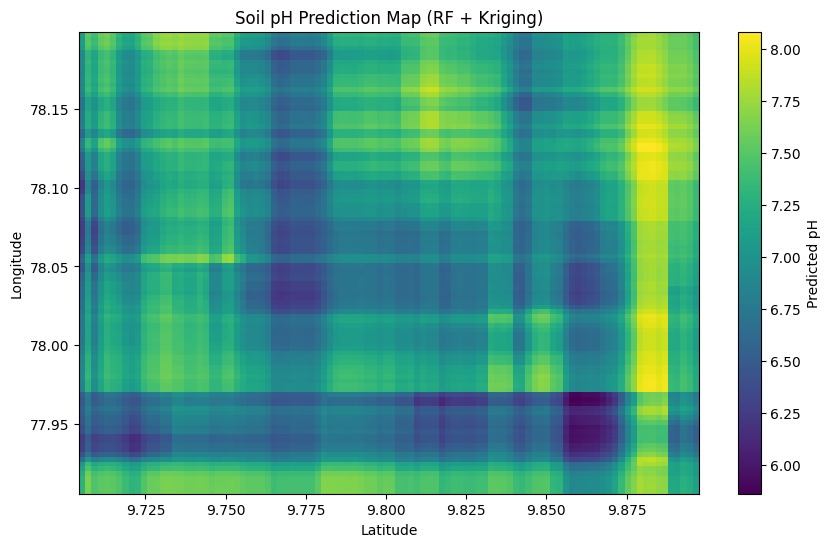

In [10]:
# 🗺️ STEP 8: Plot Final Soil Property Map
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(final_prediction, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()),
           origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Predicted pH')  # <-- Adjust label if needed
plt.title("Soil pH Prediction Map (RF + Kriging)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(False)
plt.show()